# Predicting wine quality

This problem deals with predicting red wine quality. Picking up good wines takes professional sommelier a lot of knowledge and experience, they say. Let us see if ML can do this job.

The [data](https://archive.ics.uci.edu/ml/datasets/wine+quality) for this problem are the results of a chemical analysis of vinho verde wine samples, from the north of Portugal. Your goal is to predict wine quality based on physicochemical tests. 

Attributes of the data are:

* fixed acidity 
* volatile acidity 
* citric acid 
* residual sugar 
* chlorides 
* free sulfur dioxide 
* total sulfur dioxide 
* density 
* pH 
* sulphates 
* alcohol 
* quality (score between 0 and 10)

### Exploring the data

In [70]:
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import csv
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm


import xgboost as xgb

%matplotlib inline

Load the data from `wine_data.csv`. If there are any missing values or non-numerical features, fix them.

In [4]:
data = pd.read_csv("wine_data.csv", sep = ";")

Let's have a quick look at the data.

In [5]:
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Preparing the subsets

Split the dataset into three subsets: train, CV and test using 60-20-20% rule. Keep wine quality separately as a label we want to predict.

In [86]:
cv_len, test_len = int(len(data)*0.2), int(len(data)*0.2)
data = data.sample(frac=1)

train_set = data[(2*test_len)+1:]
train_y = data[2*test_len+1:]["quality"]
del train_set["quality"]

cv_set = data[cv_len+1:test_len*2]
cv_y = data[cv_len+1:test_len*2]["quality"]
del cv_set["quality"]

test_set = data[:cv_len]
test_y = data[:cv_len]["quality"]
del test_set["quality"]

### Training logistic regression

Train logistic regression to classify the wine. Use scikit-learn implementation of this model. Tweak the hyperparameters of the model to get the maximum performance on CV set.

In [62]:
reg = LogisticRegression(C=0.75).fit(train_set, train_y)

LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
lr_train_predicted = reg.predict(train_set)
lr_cv_predicted = reg.predict(cv_set)
lr_test_predicted = reg.predict(test_set)

In [69]:
lr_train_acc = accuracy_score(train_y,lr_train_predicted)
lr_cv_acc = accuracy_score(cv_y,lr_cv_predicted)
lr_test_acc = accuracy_score(test_y,lr_test_predicted)
print('Train acuracy : ',lr_train_acc)
print('Cv accuracy : ',lr_cv_acc)

Train acuracy :  0.6
Cv accuracy :  0.6037735849056604


[LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) has a paremeter C that is responsible for regularization. Good choice of its value helps to get better accuracy on cross validation. It was a good idea to use [GridSearch](http://scikit-learn.org/stable/modules/grid_search.html) to tune this hyperparameter. On the other hand, parameters like solver have completely different meaning, changing them has no impact on the quality of the model, so using GridSearch wiht them is not that useful.
Logistic regression has a method score, which is useful to derermine the quality of the model, but is not the same as accuracy.

### Training SVM

Train support vector machines to classify the wine. Use scikit-learn implementation of this model. Tweak the hyperparameters of the model to get the maximum performance on CV set.

Keep the model and the results separate from the logistic regression. You will need them for comparing the performance of the models.

In [81]:
import time
start_time = time.time()

In [82]:
svm_classifier = svm.SVC()
svm_classifier.fit(train_set, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [83]:
svm_train_predicted = svm_classifier.predict(train_set)
svm_cv_predicted = svm_classifier.predict(cv_set)
svm_test_predicted = svm_classifier.predict(test_set)

In [84]:
svm_train_acc = accuracy_score(train_y,svm_train_predicted)
svm_cv_acc = accuracy_score(cv_y,svm_cv_predicted)
svm_test_acc = accuracy_score(test_y,svm_test_predicted)
print('Train acuracy : ',svm_train_acc)
print('Cv accuracy : ',svm_cv_acc)

Train acuracy :  0.76875
Cv accuracy :  0.5628930817610063


In [85]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8287630081176758 seconds ---


### Training XGBoost

Train XGBoost to classify the wine. Use xgboost implementation of this model. Tweak the hyperparameters of the model to get the maximum performance on CV set.

Keep the model and the results separate from two others. You will need them for comparing the performance of the models.

In [87]:
xgb_classifier = xgb.XGBClassifier(max_depth=1, reg_lambda=5)
xgb_classifier.fit(train_set, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=5, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [95]:
xgb_train_predicted = xgb_classifier.predict(train_set)
xgb_cv_predicted = xgb_classifier.predict(cv_set)
xgb_test_predicted = xgb_classifier.predict(test_set)

C:\Users\schwajka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\schwajka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\schwajka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [97]:
xgb_train_acc = accuracy_score(train_y,xgb_train_predicted)
xgb_cv_acc = accuracy_score(cv_y,xgb_cv_predicted)
xgb_test_acc = accuracy_score(test_y,xgb_test_predicted)
print('Train acuracy : ',xgb_train_acc)
print('Cv accuracy : ',xgb_cv_acc)

Train acuracy :  0.63125
Cv accuracy :  0.5566037735849056


Out of the box [XGBoost](http://xgboost.readthedocs.io/en/latest/parameter.html) works almost the same as SVM, but XGBoost overfits a lot. Parameters max_depth and lambda help to regularize the model.

### Plotting confusion matrices

Confusion matrix is a useful tool to understand what errors the models make. This code plots confusion matrices on CV set for all three models you have trained. These can help you with tweaking hyperparameters of the models as well.

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 0  0  2  1  0  0]
 [ 0  0  6 10  0  0]
 [ 0  0 61 56  0  0]
 [ 0  0 62 69  1  0]
 [ 0  0 22 23  0  0]
 [ 0  0  3  2  0  0]]
Confusion matrix, without normalization
[[ 0  0  1  1  1  0]
 [ 0  0  6 10  0  0]
 [ 0  0 55 54  8  0]
 [ 0  0 58 64 10  0]
 [ 0  0 23 20  2  0]
 [ 0  0  4  1  0  0]]
Confusion matrix, without normalization
[[ 0  0  3  0  0  0]
 [ 0  0 12  4  0  0]
 [ 0  0 94 23  0  0]
 [ 0  0 53 77  2  0]
 [ 0  0  4 35  6  0]
 [ 0  0  0  5  0  0]]


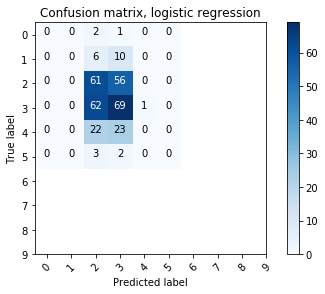

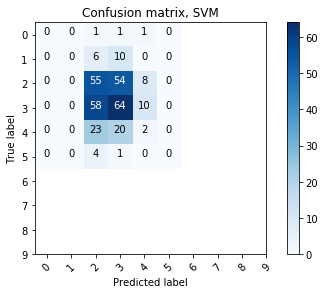

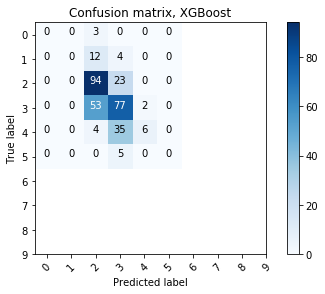

In [101]:
np.set_printoptions(precision=2)
class_names = range(10)

# Plot non-normalized confusion matrix for logistic regression
lr_cnf_matrix = confusion_matrix(cv_y, lr_cv_predicted)
plt.figure()
plot_confusion_matrix(lr_cnf_matrix, classes=class_names,
                      title='Confusion matrix, logistic regression')

# Plot non-normalized confusion matrix for SVM
svm_cnf_matrix = confusion_matrix(cv_y, svm_cv_predicted)
plt.figure()
plot_confusion_matrix(svm_cnf_matrix, classes=class_names,
                      title='Confusion matrix, SVM')

# Plot non-normalized confusion matrix for XGBoost
xgb_cnf_matrix = confusion_matrix(cv_y, xgb_cv_predicted)
plt.figure()
plot_confusion_matrix(xgb_cnf_matrix, classes=class_names,
                      title='Confusion matrix, XGBoost')

### Check test set performance

Now, check the accuracy of all three models on the test set and compare it with the CV test accuracy. Explain the results.

In [102]:
print ('Logistic regression : ', lr_test_acc)
print ('SVM : ', svm_test_acc)
print ('XGBoost', xgb_test_acc)

Logistic regression :  0.5297805642633229
SVM :  0.5172413793103449
XGBoost 0.6018808777429467


Performance of SVM and XGBoost is almost the same and much better than Logistic regression. There are several ways to improve the performance even more.
* Choose better hyperparameters of the model. This way is quite hard and requires deep understanding of the nature of the models.
* Add more features. Usually new features like some powers or combinations of features can significantly increase the accuracy, but can also increase overfitting.
* Explore the dataset in grater detail. For example, there is quite small number of samples of some classes so the model cannot get good results on that classes. It might be a good idea to remove those classes from training data. Also dataset can contain some outliers and contradictories. 